**Proyecto Waze: análisis de regresión para la predicción de la deserción de usuarios**

Introducción

Este reporte presenta un análisis de regresión logística binomial para predecir la deserción de usuarios en la aplicación Waze.

El objetivo es construir un modelo que permita identificar los factores que influyen en la deserción y proporcionar información valiosa para la implementación de estrategias de retención.

Este análisis se realiza a solicitud de la dirección de Waze, con el fin de mejorar la comprensión del comportamiento de los usuarios y reducir la tasa de deserción.

Metodología PACE

Este análisis sigue el marco PACE (Plan, Analyze, Construct, Execute) para un enfoque estructurado y orientado a resultados.

1. PACE: Planificar

Objetivo: Construir un modelo de regresión logística binomial para predecir la deserción de usuarios.
Variables:
Variable dependiente (objetivo): label (deserción de usuarios: "retained" o "churned")
Variables independientes (predictoras): Varias características de los usuarios, como el número de sesiones, el número de viajes, etc.
Tipo de modelo: Regresión logística binomial.
2. PACE: Analizar

Importación de librerías y carga de datos:

In [ ]:
# Paquetes para numéricos + dataframes
import pandas as pd
import numpy as np

# Paquetes para visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Paquetes para Regresión Logística y Matriz de Confusión
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, \
    recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

# Cargar el conjunto de datos
df = pd.read_csv('waze_dataset.csv')

Análisis exploratorio de datos (EDA):

In [ ]:
# Explorar la forma y la información del dataframe
print(df.shape)
df.info()

(14999, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


In [ ]:
# Verificar valores faltantes
print("Valores faltantes en 'label':", df['label'].isnull().sum())

Valores faltantes en 'label': 700


In [ ]:
# Mostrar las primeras filas
print(df.head())

   ID     label  sessions  drives  total_sessions  n_days_after_onboarding  \
0   0  retained       283     226      296.748273                     2276   
1   1  retained       133     107      326.896596                     1225   
2   2  retained       114      95      135.522926                     2651   
3   3  retained        49      40       67.589221                       15   
4   4  retained        84      68      168.247020                     1562   

   total_navigations_fav1  total_navigations_fav2  driven_km_drives  \
0                     208                       0       2628.845068   
1                      19                      64      13715.920550   
2                       0                       0       3059.148818   
3                     322                       7        913.591123   
4                     166                       5       3950.202008   

   duration_minutes_drives  activity_days  driving_days   device  
0              1985.775061           

In [ ]:
# Eliminar la columna 'ID'
df = df.drop('ID', axis=1)

# Verificar el balance de clases
print(df['label'].value_counts(normalize=True))

label
retained    0.822645
churned     0.177355
Name: proportion, dtype: float64


In [ ]:
# Resumen estadístico
print(df.describe())

           sessions        drives  total_sessions  n_days_after_onboarding  \
count  14999.000000  14999.000000    14999.000000             14999.000000   
mean      80.633776     67.281152      189.964447              1749.837789   
std       80.699065     65.913872      136.405128              1008.513876   
min        0.000000      0.000000        0.220211                 4.000000   
25%       23.000000     20.000000       90.661156               878.000000   
50%       56.000000     48.000000      159.568115              1741.000000   
75%      112.000000     93.000000      254.192341              2623.500000   
max      743.000000    596.000000     1216.154633              3500.000000   

       total_navigations_fav1  total_navigations_fav2  driven_km_drives  \
count            14999.000000            14999.000000      14999.000000   
mean               121.605974               29.672512       4039.340921   
std                148.121544               45.394651       2502.149334 

In [ ]:
# Crear la característica 'km_per_driving_day'
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']

# Resumen estadístico de 'km_per_driving_day'
print(df['km_per_driving_day'].describe())

count    1.429900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.675616e+02
50%      3.237524e+02
75%      7.415597e+02
max               inf
Name: km_per_driving_day, dtype: float64


In [ ]:
# Convertir valores infinitos a cero
df.loc[df['km_per_driving_day'] == np.inf, 'km_per_driving_day'] = 0

# Resumen estadístico de 'km_per_driving_day'
print(df['km_per_driving_day'].describe())

count    14299.000000
mean       567.010426
std        970.136935
min          0.000000
25%        136.168003
50%        273.301012
75%        543.473676
max       8898.716275
Name: km_per_driving_day, dtype: float64


In [ ]:
# Crear la característica 'professional_driver'
df['professional_driver'] = np.where((df['drives'] >= 60) & (df['driving_days'] >= 15), 1, 0)

# Verificar la cuenta de profesionales y no profesionales
print(df['professional_driver'].value_counts())

# Verificar la tasa de deserción en cada clase
print(df.groupby(['professional_driver'])['label'].value_counts(normalize=True))

professional_driver
0    11811
1     2488
Name: count, dtype: int64
professional_driver  label   
0                    retained    0.801202
                     churned     0.198798
1                    retained    0.924437
                     churned     0.075563
Name: proportion, dtype: float64


3. PACE: construir

Preparación de variables:

3a. Preparando variables

In [ ]:
# Verificar tipos de datos y valores faltantes
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   label                    14299 non-null  object 
 1   sessions                 14999 non-null  int64  
 2   drives                   14999 non-null  int64  
 3   total_sessions           14999 non-null  float64
 4   n_days_after_onboarding  14999 non-null  int64  
 5   total_navigations_fav1   14999 non-null  int64  
 6   total_navigations_fav2   14999 non-null  int64  
 7   driven_km_drives         14999 non-null  float64
 8   duration_minutes_drives  14999 non-null  float64
 9   activity_days            14999 non-null  int64  
 10  driving_days             14999 non-null  int64  
 11  device                   14999 non-null  object 
 12  km_per_driving_day       14999 non-null  float64
 13  professional_driver      14999 non-null  int64  
dtypes: float64(4), int64(8

In [ ]:
# Eliminar filas con valores faltantes en 'label'
df = df.dropna(subset=['label'])

In [ ]:
# Imputar valores atípicos
for column in ['sessions', 'drives', 'total_sessions', 'total_navigations_fav1',
               'total_navigations_fav2', 'driven_km_drives', 'duration_minutes_drives']:
    threshold = df[column].quantile(0.95)
    df.loc[df[column] > threshold, column] = threshold

# Resumen estadístico después de la imputación
print(df.describe())

           sessions        drives  total_sessions  n_days_after_onboarding  \
count  14299.000000  14299.000000    14299.000000             14299.000000   
mean      76.539688     63.964683      183.716746              1751.822505   
std       67.243178     55.127927      118.719242              1008.663834   
min        0.000000      0.000000        0.220211                 4.000000   
25%       23.000000     20.000000       90.457733               878.500000   
50%       56.000000     48.000000      158.718571              1749.000000   
75%      111.000000     93.000000      253.540450              2627.500000   
max      243.000000    200.000000      455.428324              3500.000000   

       total_navigations_fav1  total_navigations_fav2  driven_km_drives  \
count            14299.000000            14299.000000      14299.000000   
mean               114.562767               27.187216       3944.556684   
std                124.378550               36.715302       2218.353910 

In [ ]:
# Crear columna binaria "label2"
df['label2'] = np.where(df['label']=='churned', 1, 0)
df[['label', 'label2']].tail()

,label,label2
14994,retained,0
14995,retained,0
14996,retained,0
14997,churned,1
14998,retained,0


Tarea 3b. Determinar si se han cumplido los supuestos

Tarea 3b. Determinar si se han cumplido los supuestos
Los siguientes son los supuestos de la regresión logística:

Observaciones independientes (Se refiere a cómo se recogieron los datos).

Ausencia de valores atípicos extremos

Poca o ninguna multicolinealidad entre los predictores X

Relación lineal entre X y el logit de y

Para el primer supuesto, puede asumir que las observaciones son independientes para este proyecto.

El segundo supuesto ya se ha abordado.

El último supuesto se verificará después de la modelización.

In [ ]:
df_numeric = df.select_dtypes(include=['number'])  # Filtrar solo números
correlation_matrix = df_numeric.corr(method='pearson')  # Calcular correlación
print(correlation_matrix)

                         sessions    drives  total_sessions  \
sessions                 1.000000  0.996942        0.597190   
drives                   0.996942  1.000000        0.595286   
total_sessions           0.597190  0.595286        1.000000   
n_days_after_onboarding  0.007101  0.006940        0.006596   
total_navigations_fav1   0.001858  0.001058        0.000187   
total_navigations_fav2   0.008536  0.009505        0.010371   
driven_km_drives         0.002996  0.003445        0.001016   
duration_minutes_drives -0.004545 -0.003889       -0.000338   
activity_days            0.025113  0.024357        0.015755   
driving_days             0.020294  0.019608        0.012953   
km_per_driving_day      -0.012540 -0.011929       -0.015717   
professional_driver      0.443654  0.444425        0.254434   
label2                   0.034911  0.035865        0.024568   

                         n_days_after_onboarding  total_navigations_fav1  \
sessions                                0

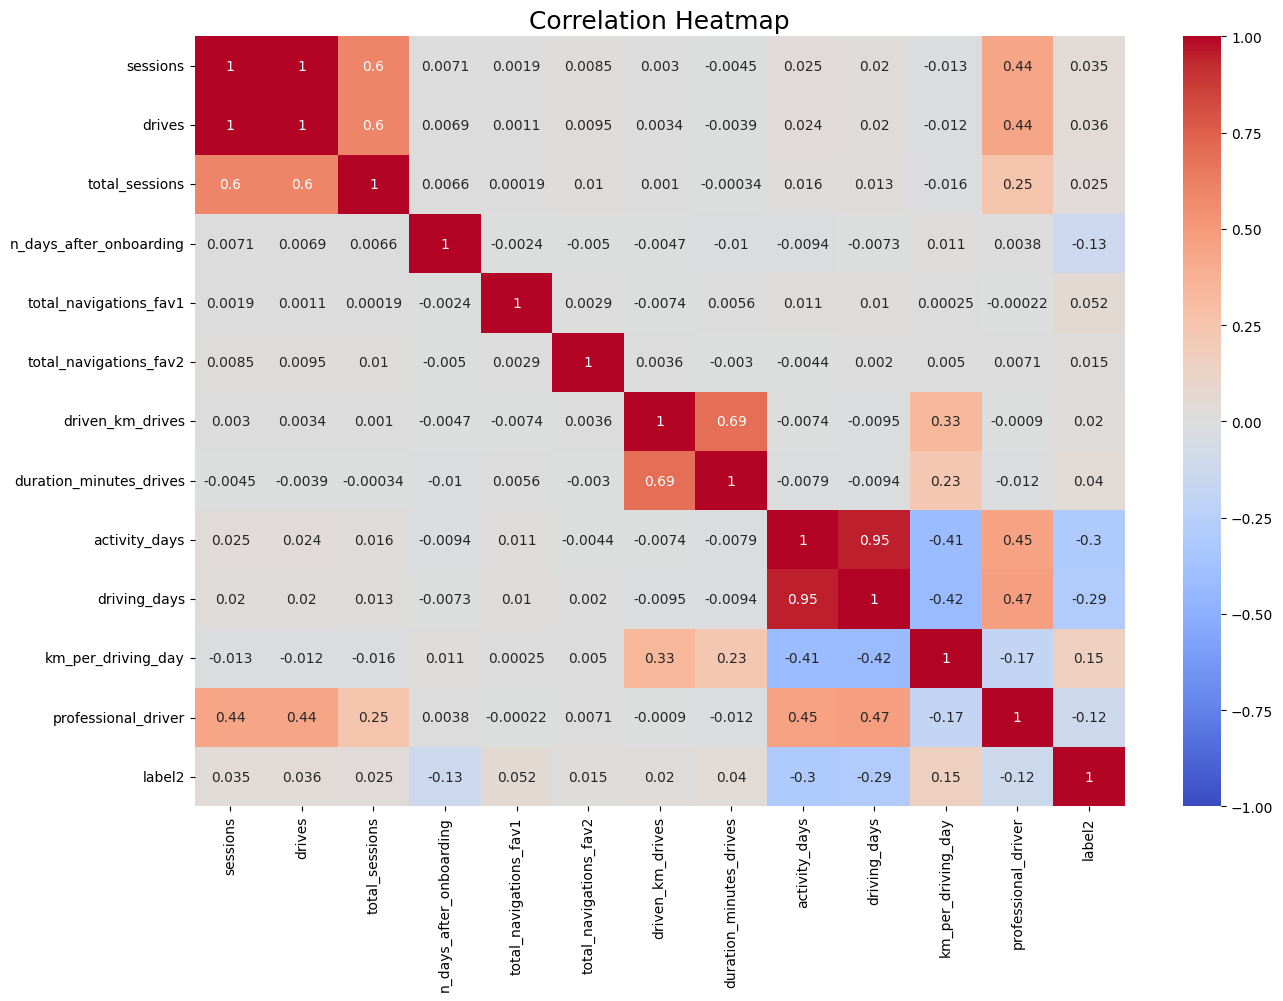

In [ ]:
# Filtrar solo las columnas numéricas
df_numeric = df.select_dtypes(include=['number'])

# Crear el heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(df_numeric.corr(method='pearson'), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap', fontsize=18)
plt.show()

3c. Crear variables dummies

In [ ]:
# Crear nueva variable "device2"
df['device2'] = np.where(df['device']=='Android', 0, 1)
df[['device', 'device2']].tail()

,device,device2
14994,iPhone,1
14995,Android,0
14996,iPhone,1
14997,iPhone,1
14998,iPhone,1


3. Model building

In [ ]:
# Aislar variables predictoras
X = df.drop(columns = ['label', 'label2', 'device', 'sessions', 'driving_days'])

In [ ]:
# Aislar variable objetivo
y = df['label2']

In [ ]:
# División entrenamiento-prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [ ]:
X_train.head()

,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,km_per_driving_day,professional_driver,device2
152,108,186.192746,3116,243,124,8898.677337,4668.116791,24,593.247752,1,1
11899,2,3.487590,794,114,18,3286.545691,1780.902733,5,3286.545691,0,1
10937,139,347.106403,331,4,7,7400.838975,2349.305267,15,616.736581,0,0
669,108,455.428324,2320,11,4,6566.424830,4558.459870,18,410.401552,1,1
8406,10,89.475821,2478,135,0,1271.248661,938.711572,27,74.779333,0,1


In [ ]:
# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Entrenar el modelo
model = LogisticRegression(penalty=None, max_iter=1000, solver='saga')
model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, penalty=None, solver='saga')

In [ ]:
# Obtener coeficientes del modelo
coeficientes = pd.Series(model.coef_[0], index=X.columns)
print(coeficientes)

drives                     0.108364
total_sessions             0.043416
n_days_after_onboarding   -0.404648
total_navigations_fav1     0.156257
total_navigations_fav2     0.036977
driven_km_drives          -0.025446
duration_minutes_drives    0.134422
activity_days             -0.948650
km_per_driving_day         0.016446
professional_driver       -0.007719
device2                    0.008093
dtype: float64


In [ ]:
model.intercept_

array([-1.86482897])

In [ ]:
# Obtener el intercept
print("Intercept:", model.intercept_)

Intercept: [-1.86482897]


In [ ]:
# Generar predicciones en los datos de prueba
y_preds = model.predict(X_test_scaled)

In [ ]:
# Evaluar el modelo
accuracy = model.score(X_test_scaled, y_test)
print("Model Accuracy:", accuracy)

Model Accuracy: 0.8248951048951049


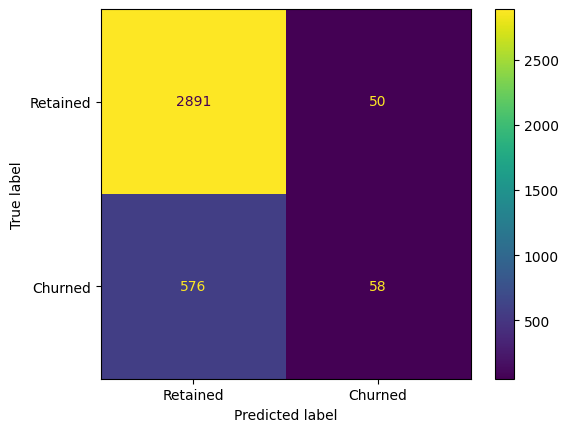

In [ ]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Retained', 'Churned'])
disp.plot()
plt.show()

In [ ]:
# Cálculo de precisión y recall manualmente
precision = cm[1,1] / (cm[0,1] + cm[1,1])
recall = cm[1,1] / (cm[1,0] + cm[1,1])
print("Precision:", precision)
print("Recall:", recall)

Precision: 0.5370370370370371
Recall: 0.0914826498422713


In [ ]:
# Reporte de clasificación
target_labels = ['retained', 'churned']
print(classification_report(y_test, y_preds, target_names=target_labels))

              precision    recall  f1-score   support

    retained       0.83      0.98      0.90      2941
     churned       0.54      0.09      0.16       634

    accuracy                           0.82      3575
   macro avg       0.69      0.54      0.53      3575
weighted avg       0.78      0.82      0.77      3575



In [ ]:
# Generar probabilidades y log-odds para análisis de linealidad
training_probabilities = model.predict_proba(X_train_scaled)

In [ ]:
# Crear dataframe de log-odds
logit_data = X_train.copy()
logit_data['logit'] = [np.log(prob[1] / prob[0]) for prob in training_probabilities]

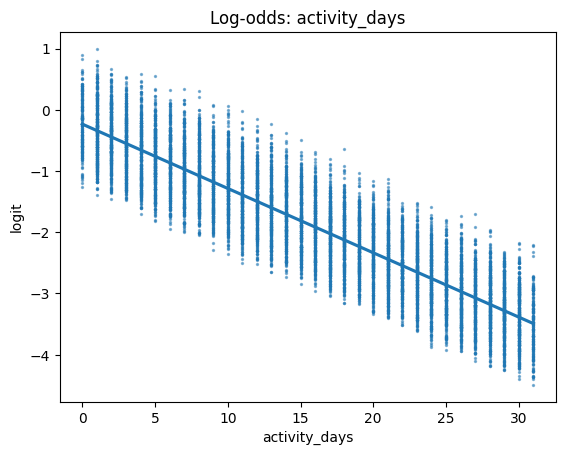

In [ ]:
# Regplot para verificar la linealidad
sns.regplot(x='activity_days', y='logit', data=logit_data, scatter_kws={'s': 2, 'alpha': 0.5})
plt.title('Log-odds: activity_days')
plt.show()

**Recomendaciones**

Mejorar el balance del modelo: ajustar la selección de variables, aplicar técnicas de sobremuestreo/submuestreo y probar escalado de datos para mejorar el recall.

Agregar nuevas variables: incorporar métricas de uso en la app (informes de tráfico, consultas de rutas alternativas) y optimizar la variable km_per_driving_day.

Reducir multicolinealidad: eliminar redundancias entre sessions y drives, así como activity_days y driving_days.
Probar otros modelos: evaluar Random Forest, XGBoost o modelos de boosting para mejorar la capacidad predictiva.

Optimizar tratamiento de outliers: considerar otras estrategias como Winsorization en lugar de recortar valores al percentil 95.

**Conclusiones**

Los días activos predicen mejor la retención: activity_days es la variable más influyente; mayor uso reduce la probabilidad de churn.

El modelo tiene baja capacidad de predicción de churn: alto accuracy (82%), pero bajo recall (9%), lo que significa que falla en identificar usuarios en riesgo.

Los conductores profesionales tienen menor churn: su tasa de abandono es del 7.6% frente al 19.9% de los usuarios regulares.

Multicolinealidad y outliers impactan el modelo: se requiere mejorar la selección de variables y su procesamiento para mayor precisión.